In [1]:
# Import libraries

%tensorflow_version 2.x

import os
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow 2.x selected.


In [0]:
# Limit tensorflow logs to error

logger = tf.get_logger()
logger.setLevel = logging.ERROR

In [3]:
# Download the Cats/Dogs dataset
# Much thanks to Microsoft Research

dataset = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip', extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [4]:
# Inspect dataset directory file structure

dataset_dir = os.path.dirname(dataset)
!find $dataset_dir -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [0]:
# Define dataset variables

dataset_dir_base = os.path.join(dataset_dir, 'cats_and_dogs_filtered')
dataset_dir_train = os.path.join(dataset_dir_base, 'train')
dataset_dir_validation = os.path.join(dataset_dir_base, 'validation')
dataset_dir_train_dogs = os.path.join(dataset_dir_train, 'dogs')
dataset_dir_train_cats = os.path.join(dataset_dir_train, 'cats')
dataset_dir_validation_dogs = os.path.join(dataset_dir_validation, 'dogs')
dataset_dir_validation_cats = os.path.join(dataset_dir_validation, 'cats')

In [6]:
# Get number of images in dataset

train_dogs = len(os.listdir(dataset_dir_train_dogs))
train_cats = len(os.listdir(dataset_dir_train_cats))
validation_dogs = len(os.listdir(dataset_dir_validation_dogs))
validation_cats = len(os.listdir(dataset_dir_validation_cats))

total_train = train_dogs + train_cats
total_validation = validation_dogs + validation_cats

print(f'This dataset has a total of {total_train} training images and {total_validation} validation images')
print(f'Training dog images: {train_dogs}')
print(f'Training cat images: {train_cats}')
print(f'Validation dog images: {validation_dogs}')
print(f'Validation cat images: {validation_cats}')

This dataset has a total of 2000 training images and 1000 validation images
Training dog images: 1000
Training cat images: 1000
Validation dog images: 500
Validation cat images: 500


In [0]:
# Define training and validation data generators

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
# Define model constants

BATCH_SIZE = 100
IMAGE_HEIGHT = 300
EPOCHS = 100

In [9]:
# Create training and validation data generators

train_data_generator = train_image_generator.flow_from_directory(
    directory = dataset_dir_train,
    batch_size = BATCH_SIZE,
    target_size = (IMAGE_HEIGHT, IMAGE_HEIGHT),
    class_mode = 'binary',
)

validation_data_generator = validation_image_generator.flow_from_directory(
    directory = dataset_dir_validation,
    batch_size = BATCH_SIZE,
    target_size = (IMAGE_HEIGHT, IMAGE_HEIGHT),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


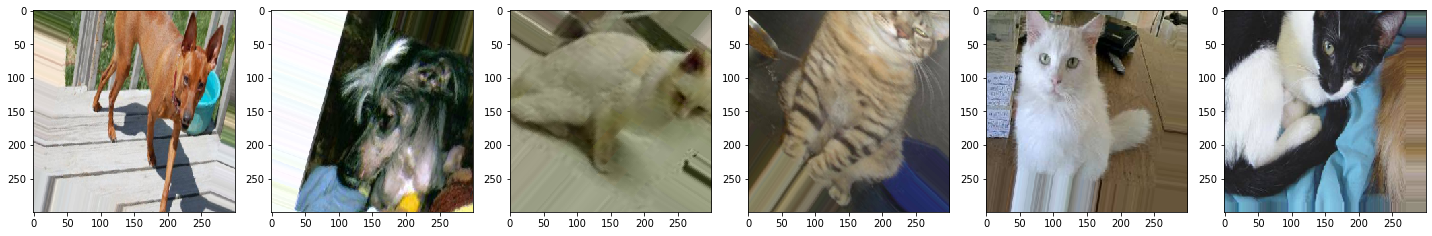

In [10]:
# Visualize some of the training images

imgs, _ = next(train_data_generator)
sample_imgs = imgs[:6]

fig, axes = plt.subplots(1, 6, figsize = (20, 20))
axes = axes.flatten()
for img, ax in zip(sample_imgs, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [0]:
# Define the model

model = tf.keras.Sequential([
                     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape = (300, 300, 3)), 
                     tf.keras.layers.MaxPooling2D(2, 2), 
                     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
                     tf.keras.layers.MaxPooling2D(2, 2),  
                     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
                     tf.keras.layers.MaxPooling2D(2, 2), 
                     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
                     tf.keras.layers.MaxPooling2D(2, 2), 
                     tf.keras.layers.Flatten(),
                     tf.keras.layers.Dense(512, activation='relu'),
                     tf.keras.layers.Dropout(0.2),
                     tf.keras.layers.Dense(1, activation='sigmoid')   
                ])

In [12]:
# Visualiize model layer output

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [0]:
# Epoch callback class

class epochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.95):
            epoch_acc = logs.get('accuracy')
            print(f'\n\nModel accuracy currently at {epoch_acc}. Stopping training...\n\n')
            self.model.stop_training = True

In [0]:
# Compile the model

model.compile(loss = 'binary_crossentropy', optimizer=RMSprop(lr = 0.001), metrics=['accuracy'])

In [15]:
# Fit the model

history = model.fit_generator(
    train_data_generator,
    epochs = EPOCHS,
    steps_per_epoch = int(total_train/BATCH_SIZE),
    validation_data = validation_data_generator,
    validation_steps = int(total_validation/BATCH_SIZE),
    callbacks = [epochCallback()]
)

Epoch 1/100
20/20 [==============================] - 49s 2s/step - loss: 1.0706 - accuracy: 0.5045 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 43s 2s/step - loss: 0.6953 - accuracy: 0.5105 - val_loss: 0.6873 - val_accuracy: 0.5760
Epoch 3/100
20/20 [==============================] - 43s 2s/step - loss: 0.6951 - accuracy: 0.5030 - val_loss: 0.6889 - val_accuracy: 0.5710
Epoch 4/100
20/20 [==============================] - 43s 2s/step - loss: 0.7012 - accuracy: 0.5190 - val_loss: 0.6752 - val_accuracy: 0.6170
Epoch 5/100
20/20 [==============================] - 43s 2s/step - loss: 0.7117 - accuracy: 0.5510 - val_loss: 2.1327 - val_accuracy: 0.5000
Epoch 6/100
20/20 [==============================] - 43s 2s/step - loss: 0.7560 - accuracy: 0.5605 - val_loss: 0.6696 - val_accuracy: 0.6100
Epoch 7/100
20/20 [==============================] - 43s 2s/step - loss: 0.6607 - accuracy: 0.6155 - val_loss: 0.6380 - val_accuracy: 0.6300
Epoch 8/100
2

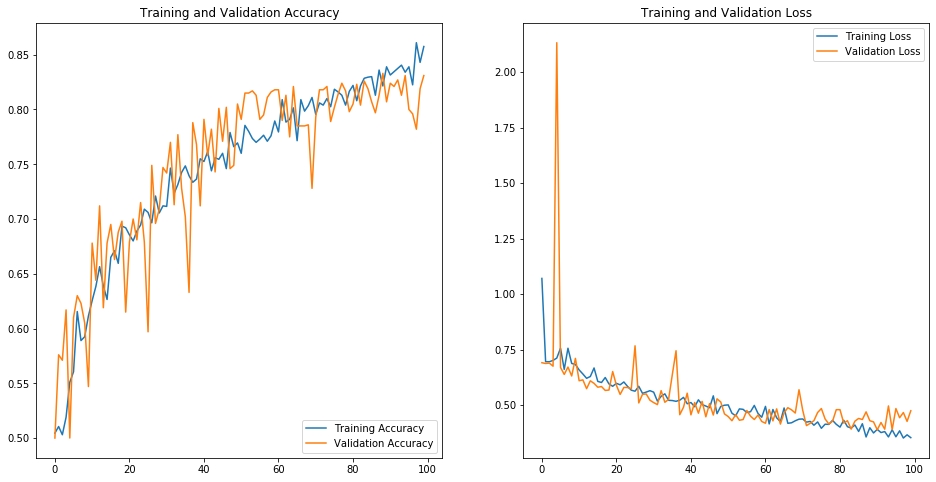

In [17]:
# Visualize model training

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Accuracy')
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), validation_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')

plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), validation_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')

plt.show()